In [3]:
from collections import Counter, defaultdict
import re
import time
from concurrent.futures import ThreadPoolExecutor
import random
import string
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer, AutoModelForSequenceClassification
from sentence_transformers import SentenceTransformer
import torch

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from bertopic import BERTopic
from bertopic.representation import TextGeneration
from umap import UMAP
from hdbscan import HDBSCAN

[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
#### **SET GLOBAL VARIABLES**

In [5]:
# Make sure the working directory is set correctly
print("Initial working directory: ", os.getcwd())
os.chdir("../..")
print("New working directory: ", os.getcwd())

Initial working directory:  C:\Cambridge\bank-of-eng-risk-monitoring\boe_risk_monitoring\nlp
New working directory:  C:\Cambridge\bank-of-eng-risk-monitoring


In [8]:
ROOT_FPATH = os.getcwd()
DATA_FOLDER = "data"
AGGREGATED_DATA_FOLDER_NAME = "aggregated"
transcripts_FNAME = "transcripts.parquet"
transcripts_FPATH = f"{ROOT_FPATH}/{DATA_FOLDER}/{AGGREGATED_DATA_FOLDER_NAME}/{transcripts_FNAME}"
GLOSSARY_FNAME = "glossary_dictionary_citigroup.csv"
GLOSSARY_FPATH = f"{ROOT_FPATH}/{DATA_FOLDER}/{GLOSSARY_FNAME}"

In [9]:
# Read in the data
df_transcripts = pd.read_parquet(transcripts_FPATH)
df_transcripts

,text,fiscal_period_ref,speaker,role,page,section,reporting_period,date_of_call,bank,document_type,source
0,"Hello, and welcome to Citi's First Quarter 202...",quarter,Operator,Host,1,Introduction,Q1_2023,2023-04-14,Citigroup,transcript,"Operator (Host)\nCitigroup, Q1, 2023 Earnings ..."
1,"Ms. Landis, you may begin.",quarter,Operator,Host,1,Introduction,Q1_2023,2023-04-14,Citigroup,transcript,"Operator (Host)\nCitigroup, Q1, 2023 Earnings ..."
2,"Thank you, operator. Good morning and thank yo...",quarter,Jennifer Landis,Host,1,Disclaimer,Q1_2023,2023-04-14,Citigroup,transcript,"Jennifer Landis (Host)\nCitigroup, Q1, 2023 Ea..."
3,"With that, I'll turn it over to Jane.",quarter,Jennifer Landis,Host,1,Introduction,Q1_2023,2023-04-14,Citigroup,transcript,"Jennifer Landis (Host)\nCitigroup, Q1, 2023 Ea..."
4,"Thank you, Jenn, hello to everyone joining us ...",quarter,Jane Fraser,CEO,1,Prepared remarks,Q1_2023,2023-04-14,Citigroup,transcript,"Jane Fraser (CEO)\nCitigroup, Q1, 2023 Earning..."
...,...,...,...,...,...,...,...,...,...,...,...
4279,Thanks very much.,quarter,Jeremy Barnum,CFO,15,Conclusion,Q4_2024,2025-01-15,JPMorgan,transcript,"Jeremy Barnum (CFO)\nJPMorgan, Q4, 2024 Earnin..."
4280,Thanks very much.,quarter,Jamie Dimon,CEO,16,Conclusion,Q4_2024,2025-01-15,JPMorgan,transcript,"Jamie Dimon (CEO)\nJPMorgan, Q4, 2024 Earnings..."
4281,See you next quarter.,quarter,Jeremy Barnum,CFO,16,Conclusion,Q4_2024,2025-01-15,JPMorgan,transcript,"Jeremy Barnum (CFO)\nJPMorgan, Q4, 2024 Earnin..."
4282,Thank you all for participating in today's con...,quarter,Operator,Host,16,Conclusion,Q4_2024,2025-01-15,JPMorgan,transcript,"Operator (Host)\nJPMorgan, Q4, 2024 Earnings C..."


#### 😊 Sentiment Analysis

In [10]:
# Let's check we don't have any missing data
df_transcripts['text'].isna().sum()

0

In [11]:
# We'll use finbert-tone for sentiment analysis which is the finetuned version of BERT for financial sentiment analysis
model_name = "yiyanghkust/finbert-tone"

In [12]:
# Check max token length for the model
model = AutoModelForSequenceClassification.from_pretrained(model_name)
print(model.config.max_position_embeddings)

512


In [13]:
# Find max token length in the dataset
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
max_tokens = df_transcripts["text"].apply(
    lambda x: len(tokenizer(x, truncation=False)["input_ids"])
).max()
print("Estimated max tokens in dataset:", max_tokens)

Estimated max tokens in dataset: 409


In [14]:
# Split the reviews into two parts for parallel processing (2x GPUs)
text_list = df_transcripts['text'].tolist()
# Split list into 2 roughly equal parts
midpoint = len(text_list) // 2
text_list_split1 = text_list[:midpoint]
text_list_split2 = text_list[midpoint:]

In [15]:
def run_sentiment_analysis_on_gpu(text_subset, model_name, device_id):
	"""
	Run sentiment analysis on a subset of text using a specified model and device.
	"""
	tokenizer = AutoTokenizer.from_pretrained(model_name)
	model = AutoModelForSequenceClassification.from_pretrained(model_name)

	clf = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device_id)

	results = []
	batch_size = 32

	for i in range(0, len(text_subset), batch_size):
		batch = text_subset[i:i+batch_size]
		batch_results = clf(batch, truncation=True, max_length=512)
		results.extend(batch_results)
		print(f"Device {device_id}: Processed {i + batch_size} reviews out of {len(text_subset)}")

	return results

In [16]:
# Run sentiment analysis on both subsets in parallel using ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=2) as executor:
    future_0 = executor.submit(run_sentiment_analysis_on_gpu, text_list_split1, model_name, 0)
    future_1 = executor.submit(run_sentiment_analysis_on_gpu, text_list_split2, model_name, 1)

    results_0 = future_0.result()
    results_1 = future_1.result()
    results = results_0 + results_1

Device set to use cpu
Device set to use cpu


Device 1: Processed 32 reviews out of 2142
Device 0: Processed 32 reviews out of 2142
Device 0: Processed 64 reviews out of 2142
Device 1: Processed 64 reviews out of 2142
Device 1: Processed 96 reviews out of 2142
Device 0: Processed 96 reviews out of 2142
Device 1: Processed 128 reviews out of 2142
Device 0: Processed 128 reviews out of 2142
Device 1: Processed 160 reviews out of 2142
Device 0: Processed 160 reviews out of 2142
Device 1: Processed 192 reviews out of 2142
Device 1: Processed 224 reviews out of 2142
Device 0: Processed 192 reviews out of 2142
Device 1: Processed 256 reviews out of 2142
Device 0: Processed 224 reviews out of 2142
Device 1: Processed 288 reviews out of 2142
Device 0: Processed 256 reviews out of 2142
Device 1: Processed 320 reviews out of 2142
Device 1: Processed 352 reviews out of 2142
Device 0: Processed 288 reviews out of 2142
Device 1: Processed 384 reviews out of 2142
Device 0: Processed 320 reviews out of 2142
Device 1: Processed 416 reviews out of

## General banks

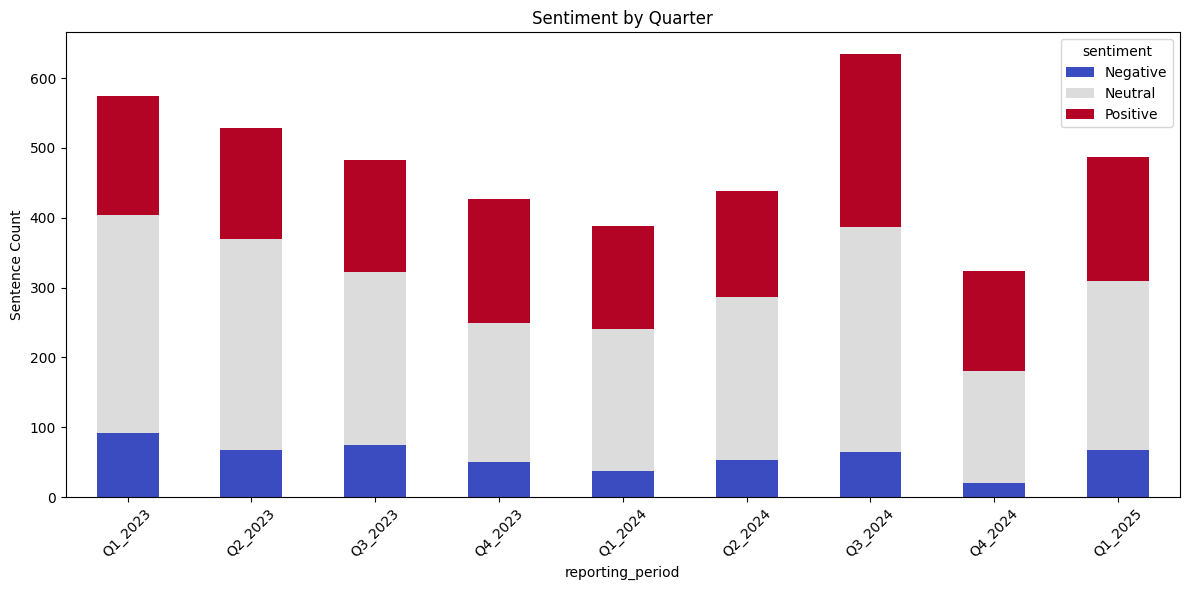

In [17]:
# Postprocess results and add to DataFrame
results_clean = [d['label'] for d in results]
df_transcripts['sentiment'] = results_clean
# Sentiment over time
sentiment_summary = df_transcripts.groupby(['reporting_period', 'sentiment']).size().unstack(fill_value=0)

# Step 1: Create a mapping from reporting_period to date_of_call
# We'll take the first call date per reporting_period (they are usually the same)
period_to_date = df_transcripts.groupby('reporting_period')['date_of_call'].min()

# Step 2: Reorder the index of sentiment_summary by the corresponding call date
sentiment_summary['date_of_call'] = sentiment_summary.index.map(period_to_date)
sentiment_summary = sentiment_summary.sort_values('date_of_call')

# Step 3: Drop the helper column (optional)
sentiment_summary = sentiment_summary.drop(columns='date_of_call')

# Step 4: Plot again
sentiment_summary.plot(kind='bar', stacked=True, figsize=(12, 6),
                       colormap='coolwarm', title='Sentiment by Quarter')
plt.ylabel("Sentence Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## By Bank

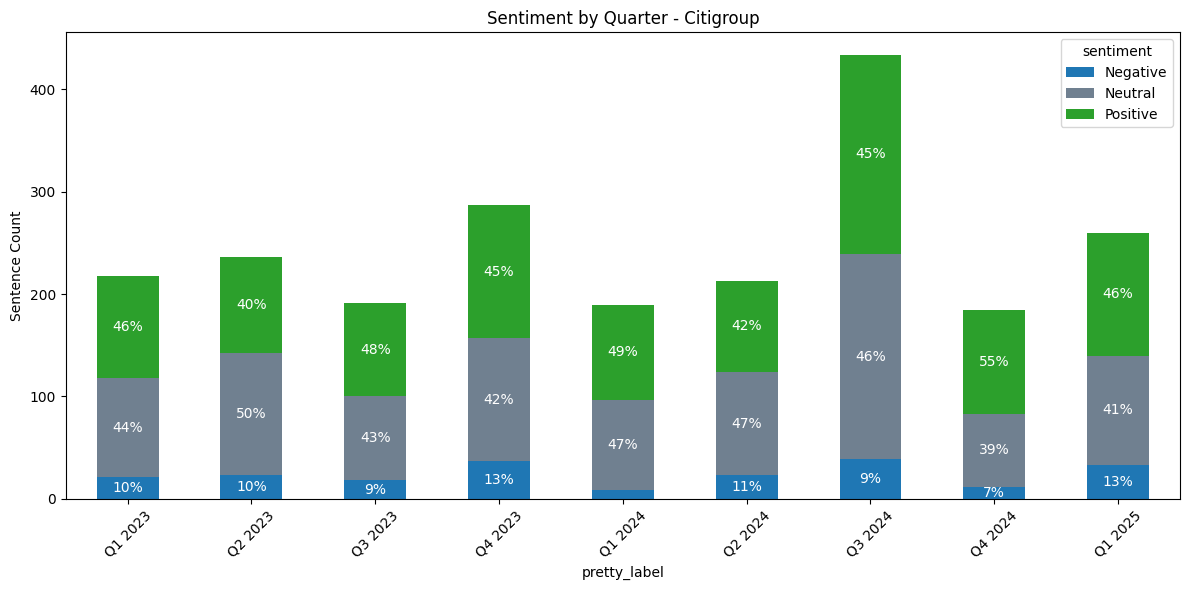

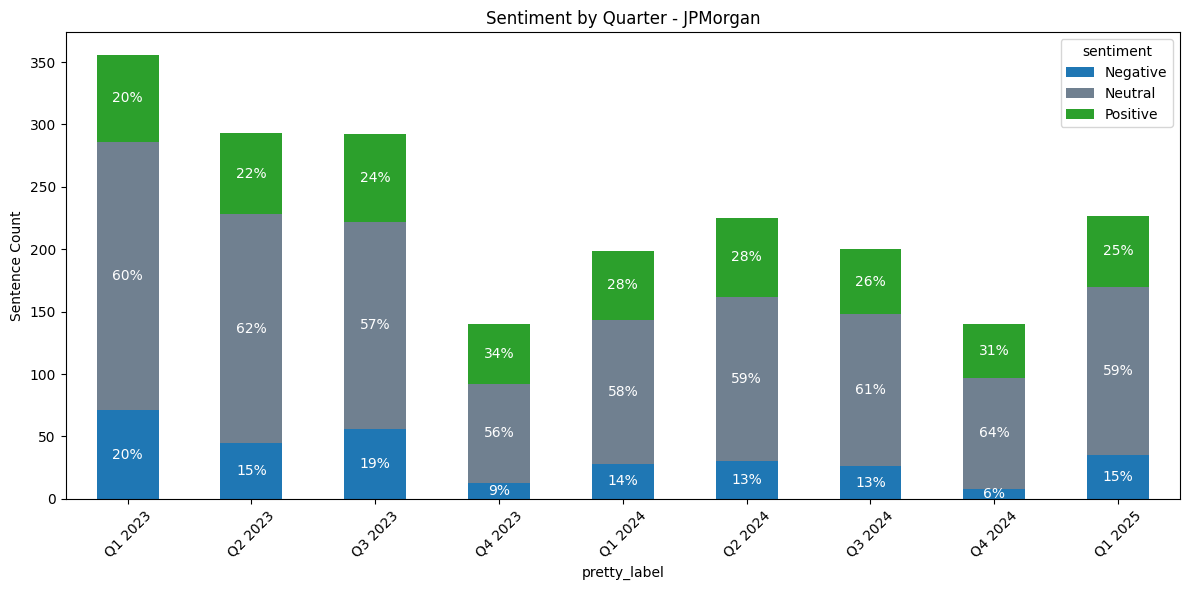

In [18]:
import matplotlib.pyplot as plt

# Group by reporting_period, bank, and sentiment
sentiment_summary = df_transcripts.groupby(['reporting_period', 'bank', 'sentiment']).size()

# Pivot to get sentiment categories as columns
sentiment_summary = sentiment_summary.unstack(fill_value=0).reset_index()

# Add date_of_call for chronological sorting
date_map = df_transcripts.groupby('reporting_period')['date_of_call'].min()
sentiment_summary['date_of_call'] = sentiment_summary['reporting_period'].map(date_map)

# Sort by date
sentiment_summary = sentiment_summary.sort_values('date_of_call')

# Format labels
sentiment_summary['pretty_label'] = sentiment_summary['reporting_period'].str.replace('_', ' ')

# Plot per bank
banks = sentiment_summary['bank'].unique()

for bank in banks:
    bank_data = sentiment_summary[sentiment_summary['bank'] == bank]
    
    # Set index for plotting
    bank_data_plot = bank_data.set_index('pretty_label')
    
    # Drop helper columns
    bank_data_plot = bank_data_plot.drop(columns=['reporting_period', 'bank', 'date_of_call'])

    # Calculate percentages
    percent_data = bank_data_plot.div(bank_data_plot.sum(axis=1), axis=0) * 100
    colors = {
        'Negative': '#1f77b4',  # Blue
        'Neutral': '#708090',   # Orange
        'Positive': '#2ca02c'   # Green
    }

    # Ensure columns match the colors
    sentiment_order = ['Negative', 'Neutral', 'Positive']

    # Plot with custom colors
    ax = bank_data_plot[sentiment_order].plot(
        kind='bar', 
        stacked=True, 
        figsize=(12, 6),
        color=[colors[s] for s in sentiment_order], 
        title=f'Sentiment by Quarter - {bank}'
    )

    plt.ylabel("Sentence Count")
    plt.xticks(rotation=45)

    # Annotate with percentages
    for idx, row in enumerate(percent_data.values):
        cumulative = 0
        for j, value in enumerate(row):
            if value > 5:  # Show only if > 5% to avoid clutter
                y = cumulative + bank_data_plot.values[idx][j] / 2
                ax.text(idx, y, f"{value:.0f}%", ha='center', va='center', fontsize=10, color='white')
            cumulative += bank_data_plot.values[idx][j]

    plt.tight_layout()
    plt.show()